# 1. Introuction

 This notebook outlines the creation, compilation, and training of a ViT network to classify 101 types of food. An extra class called "unknown" was created using images from the [iFood-2019 dataset](https://www.kaggle.com/competitions/ifood-2019-fgvc6/data) that contains 251 food types. As in the other trained models, PyTorch's pretrained weights will be used to initialize the models and no transfer learning will be applied. 
 
 The following table summarizes the model:

| Version | **ViT Type** | **Image Size** | **Patch Size** | **Encoding Layers** | **Hidden Size** | **Multi-layer Perceptron size** | **Attention Heads** | **Hidder Layer Units for Classification** | **Transfer Learning** | **Number of Epochs** | **Learning Rate** | **Scheduler** | **Params**
| ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- |
| 1 | Base | 384x384 | 16x16 | 12 | 768 | 3072 | 12 | 64 | IMAGENET1K_SWAG_E2E_V1 | 60 | 0.0001 | CosineAnnealingLR | 86.2M |

The custom vision transformer architectures have been implemented from scratch based on the paper titled ["An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale"](https://arxiv.org/abs/2010.11929). The custom library is called **vision_transformer** where the **ViT class** can be imported.

# 2. Importing Libraries

In [1]:
import os
import torch
import torchvision
import torch.backends.cudnn as cudnn
import numpy as np

from torchvision.transforms import v2
from torchinfo import summary
from pathlib import Path
from torchvision import datasets
from torch.optim.lr_scheduler import CosineAnnealingLR
#from warmup_scheduler_pytorch import WarmUpScheduler
#from timm.scheduler.cosine_lr import CosineLRScheduler

# Import custom libraries
from modules.helper_functions import set_seeds, create_dataloaders_for_vit
from modules.engine import Trainer
from modules.vision_transformer import ViT, create_dataloader_for_vit
from modules.scheduler import FixedLRSchedulerWrapper
#from modules.scheduler import WarmupCosineAnnealingLR

# Define some constants
NUM_WORKERS = os.cpu_count()
AMOUNT_TO_GET = 1.0
SEED = 42

# Define target data directory
TARGET_DIR_NAME = f"../data/food-101_{str(int(AMOUNT_TO_GET*100))}_percent"

# Setup training and test directories
TARGET_DIR = Path(TARGET_DIR_NAME)
TRAIN_DIR = TARGET_DIR / "train"
TEST_DIR = TARGET_DIR / "test"
TARGET_DIR.mkdir(parents=True, exist_ok=True)

# Create target model directory
MODEL_DIR = Path("../models")

# Set seeds
set_seeds(SEED)

# 3. Specifying Target Device

In [2]:
# Activate cuda benchmark
cudnn.benchmark = True

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

if device == "cuda":
    !nvidia-smi

Device: cuda
Sat Jan  4 18:12:38 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070      WDDM  |   00000000:01:00.0  On |                  N/A |
| 30%   40C    P8             10W /  200W |    1219MiB /  12282MiB |      4%      Default |
|                                         |                        |                  N/A |
+----------------------------------

# 4. Image Visualization

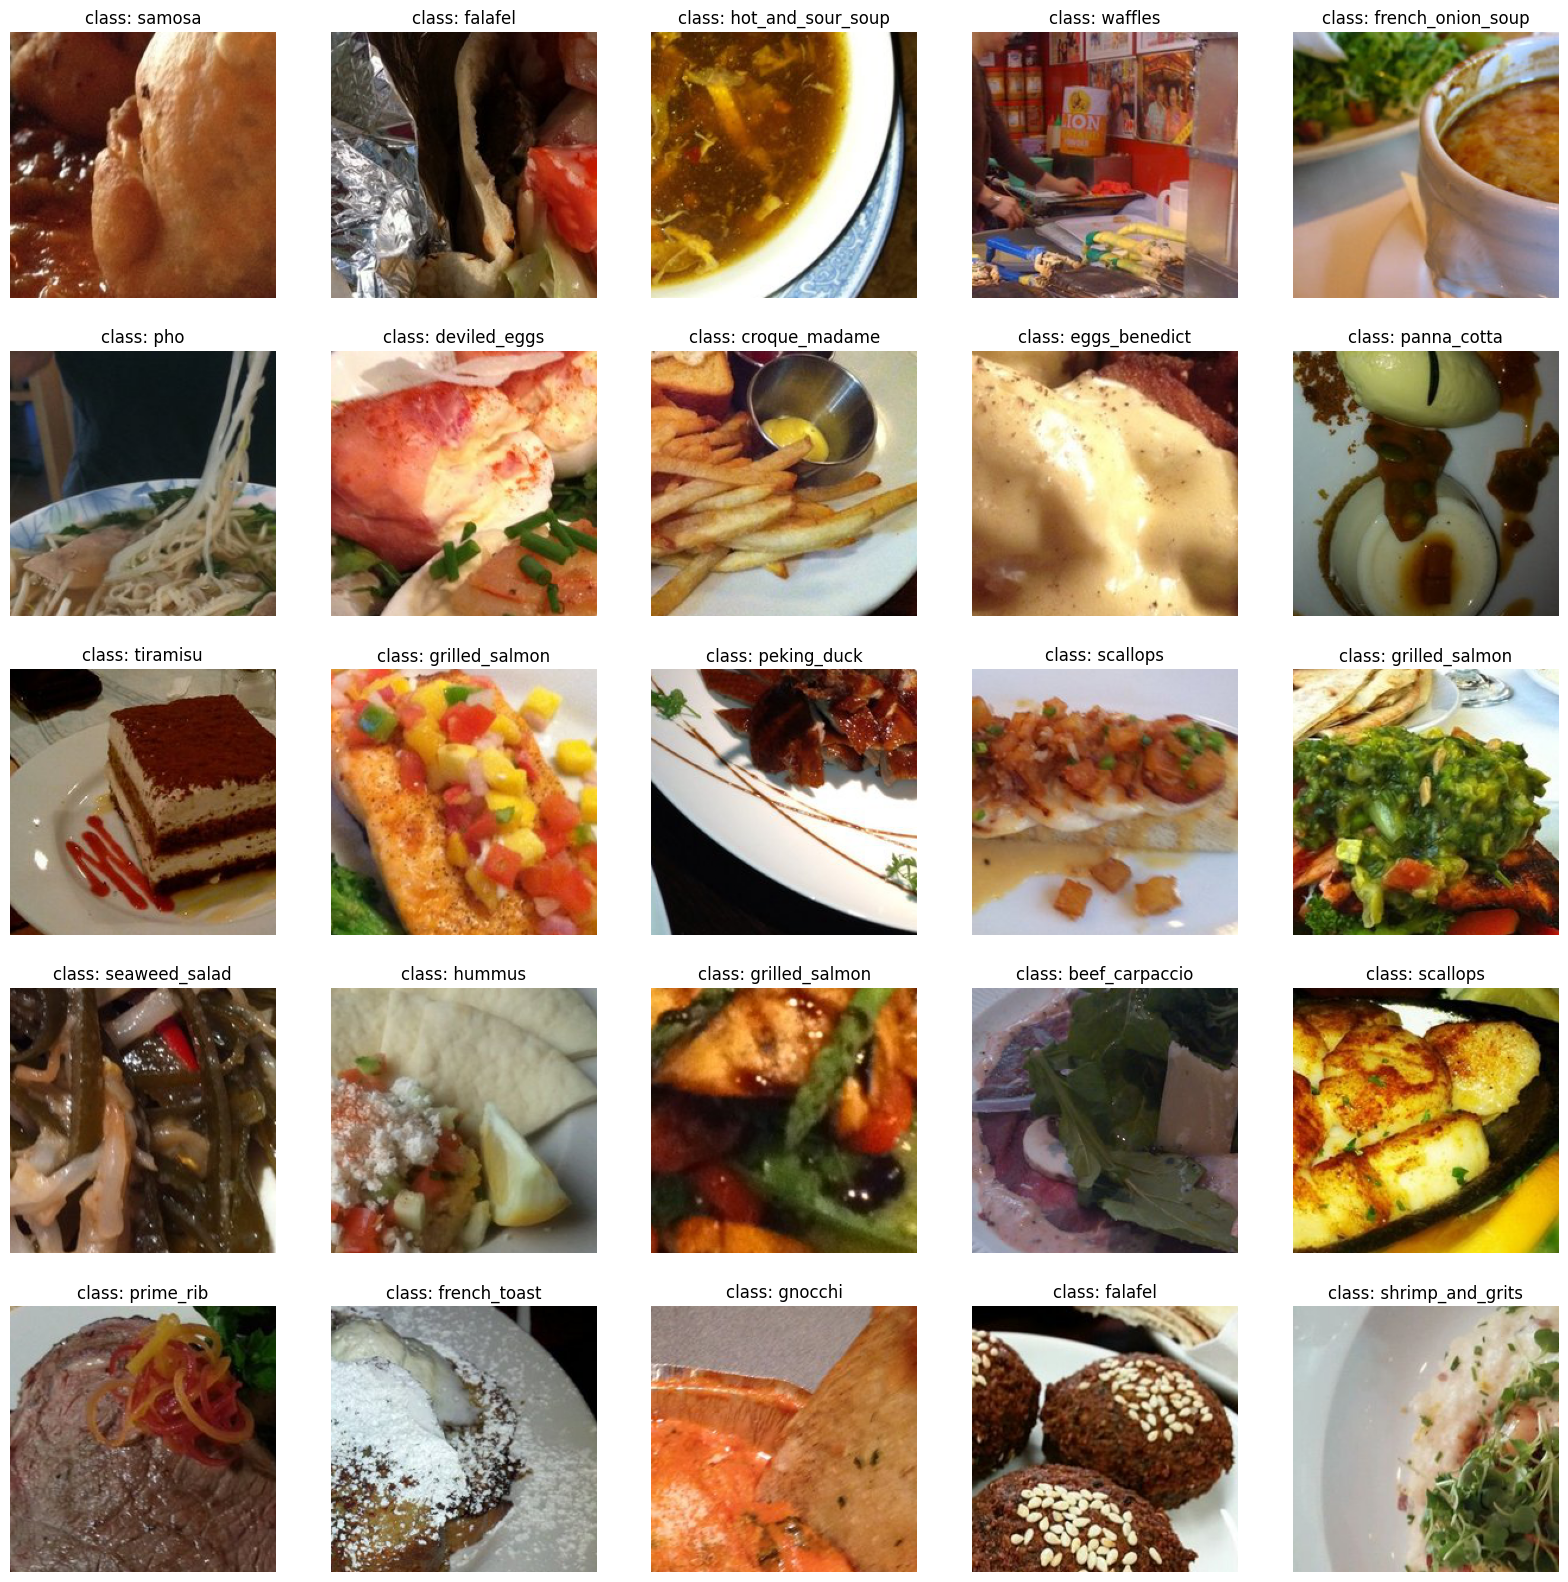

In [3]:
# Display images
_, _, _ = create_dataloader_for_vit(display_imgs=True, train_dir=TRAIN_DIR, test_dir=TEST_DIR)

# 5. Custom ViT-Base/16 - Weights: IMAGENET1K_SWAG_E2E_V1

| Version | **ViT Type** | **Image Size** | **Patch Size** | **Encoding Layers** | **Hidden Size** | **Multi-layer Perceptron size** | **Attention Heads** | **Batch Size** | **Model Weights (Initialization)** | **Number of Epochs** | **Learning Rate** | **Scheduler** | **Params**
| ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- |
| 1 | Base | 384x384 | 16x16 | 12 | 768 | 3072 | 12 | 64 | IMAGENET1K_SWAG_E2E_V1 | 60 | 0.0001 | CosineAnnealingLR | 86.2M |

In [5]:
# Create dataloaders
IMG_SIZE_2 = 384
BATCH_SIZE = 16
train_dataloader_vitb, test_dataloader_vitb, class_names = create_dataloaders_for_vit(
    vit_model="vitbase16_2",
    batch_size=BATCH_SIZE,
    train_dir=TRAIN_DIR,
    test_dir=TEST_DIR,
    aug=True,
    display_imgs=False,
    num_workers=NUM_WORKERS
    )

# Create the ViT-Base model
vitbase16_2_model = ViT(
    img_size=IMG_SIZE_2,
    in_channels=3,
    patch_size=16,
    num_transformer_layers=12,
    emb_dim=768,
    mlp_size=3072,
    num_heads=12,
    attn_dropout=0,
    mlp_dropout=0.1,
    emb_dropout=0.1,
    num_classes=len(class_names)
)

# Copy weights from torchvision.models.ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1 (note: except the header to be trained)
vitbase16_2_model.copy_weights(torchvision.models.ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1)

# And freeze the backbone except the classification head params
#vitbase16_2_model.set_params_frozen(except_head=True)

# Compile model
vitbase16_2_model = torch.compile(vitbase16_2_model, backend="aot_eager")

# Print summary
summary(vitbase16_2_model,
        input_size=(BATCH_SIZE,3,IMG_SIZE_2, IMG_SIZE_2), # try swapping this for "random_input_image_error"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

[INFO] Model weights copied successfully.
[INFO] Model weights are trainable by default. Use function set_params_frozen to freeze them.


c:\Users\ssre_\.conda\envs\.venv_pytorch_gpu\Lib\site-packages\onnxscript\converter.py:820: FutureWarning: 'onnxscript.values.Op.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
c:\Users\ssre_\.conda\envs\.venv_pytorch_gpu\Lib\site-packages\onnxscript\converter.py:820: FutureWarning: 'onnxscript.values.OnnxFunction.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()


Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
OptimizedModule (OptimizedModule)                                 [16, 3, 384, 384]    [16, 102]            --                   True
├─ViT (_orig_mod)                                                 [16, 3, 384, 384]    [16, 102]            --                   True
│    └─PatchEmbedding (embedder)                                  [16, 3, 384, 384]    [16, 577, 768]       443,904              True
│    │    └─Conv2d (conv_proj)                                    [16, 3, 384, 384]    [16, 768, 24, 24]    590,592              True
│    │    └─Flatten (flatten)                                     [16, 768, 24, 24]    [16, 768, 576]       --                   --
│    │    └─Dropout (emb_dropout)                                 [16, 577, 768]       [16, 577, 768]       --                   --
│    └─Sequential (encoder)                                  

In [6]:
print(f"Is the unknown class in the dataset?: {'unknown' in class_names}")

Is the unknown class in the dataset?: True


In [7]:
# Compute weights for the loss function
n_samples_train = [len(list(Path(TRAIN_DIR).glob(f"**/{classes}/*.jpg"))) for classes in class_names]
loss_weights = n_samples_train / np.sum(n_samples_train)
loss_weights = torch.tensor(loss_weights).float().to(device)
len(n_samples_train), loss_weights.max(), loss_weights.min()

(102, tensor(0.0122, device='cuda:0'), tensor(0.0098, device='cuda:0'))

Epoch: 10 | train_loss: 0.9198 | train_acc: 0.9699 | fpr_at_recall: 0.0002 | train_time: 16m55s | test_loss: 1.0828 | test_acc: 0.9128 | fpr_at_recall: 0.0036 | test_time: 3m18s | lr: 0.0000034227


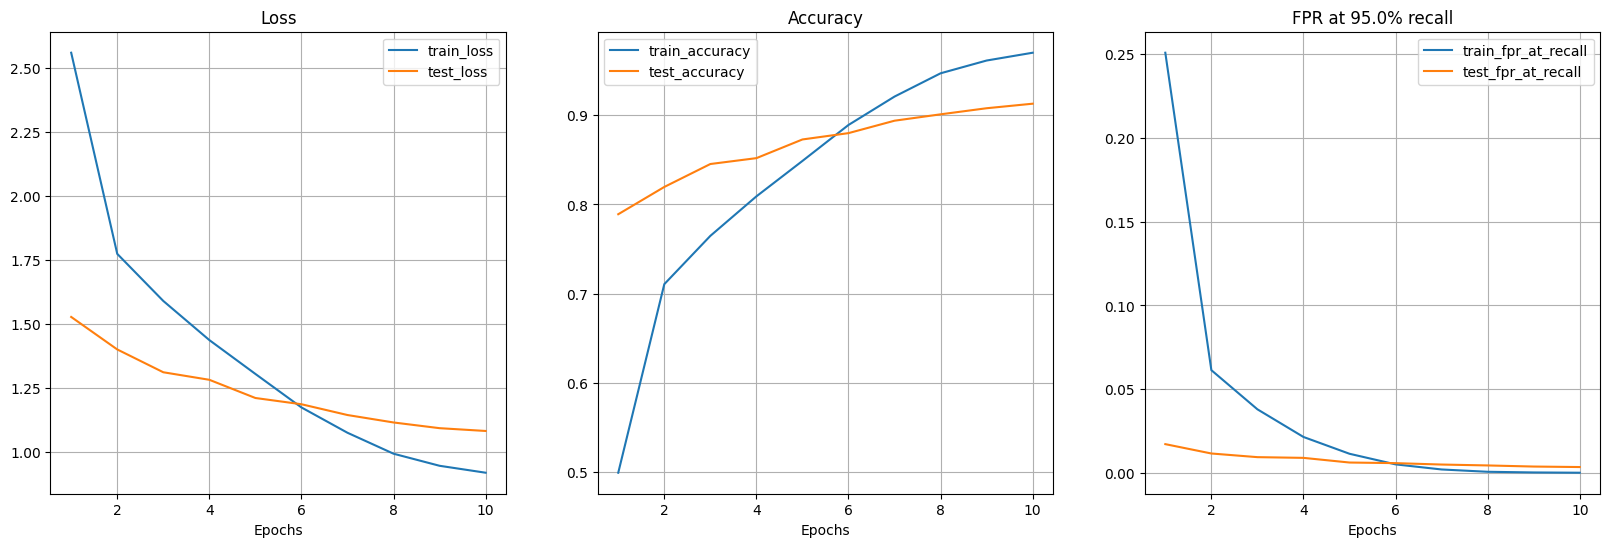

[INFO] Saving model to: ..\models\vitbase16_102_2024-01-03_best.pth
[INFO] Saving model to: ..\models\vitbase16_102_2024-01-03.pth


In [8]:
# Train the model
model_type="vitbase16_102_2025-01-03"
EPOCHS = 10
LR = 0.0001
model_name = f"{model_type}"
vitbase16_2_model_name = model_name + ".pth"

# Create optimizer
optimizer = torch.optim.AdamW(
    params=vitbase16_2_model.parameters(),
    lr=LR,
    betas=(0.9, 0.999),
    weight_decay=0.01
)

# Create loss function
loss_fn = torch.nn.CrossEntropyLoss(weight=loss_weights, label_smoothing=0.1)

# Set scheduler
scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)

# Set seeds
set_seeds(SEED)

# And train...
train = Trainer(
    model=vitbase16_2_model,
    save_best_model=True,
    mode="max", # Based on accuracy
    device=device)

vitbase16_2_results = train.fit(
    target_dir=MODEL_DIR,
    model_name=vitbase16_2_model_name,
    train_dataloader=train_dataloader_vitb,
    test_dataloader=test_dataloader_vitb,
    optimizer=optimizer,
    loss_fn=loss_fn,
    recall_threshold=0.95,
    scheduler=scheduler,
    epochs=EPOCHS,
    amp=True,
    enable_clipping=False,
    debug_mode=False,
    accumulation_steps=4,
    )

In [4]:
# Create dataloaders
IMG_SIZE_2 = 384
BATCH_SIZE = 16
train_dataloader_vitb, test_dataloader_vitb, class_names = create_dataloaders_for_vit(
    vit_model="vitbase16_2",
    batch_size=BATCH_SIZE,
    train_dir=TRAIN_DIR,
    test_dir=TEST_DIR,
    aug=True,
    display_imgs=False,
    num_workers=NUM_WORKERS
    )

# Create the ViT-Base model
vitbase16_2_model = ViT(
    img_size=IMG_SIZE_2,
    in_channels=3,
    patch_size=16,
    num_transformer_layers=12,
    emb_dim=768,
    mlp_size=3072,
    num_heads=12,
    attn_dropout=0,
    mlp_dropout=0.1,
    emb_dropout=0.1,
    num_classes=len(class_names)
)

# Copy weights from torchvision.models.ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1 (note: except the header to be trained)
vitbase16_2_model.copy_weights(torchvision.models.ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1)

# And freeze the backbone except the classification head params
#vitbase16_2_model.set_params_frozen(except_head=True)

# Compile model
vitbase16_2_model = torch.compile(vitbase16_2_model, backend="aot_eager")

# Print summary
summary(vitbase16_2_model,
        input_size=(BATCH_SIZE,3,IMG_SIZE_2, IMG_SIZE_2), # try swapping this for "random_input_image_error"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

[INFO] Model weights copied successfully.
[INFO] Model weights are trainable by default. Use function set_params_frozen to freeze them.


c:\Users\ssre_\.conda\envs\.venv_pytorch_gpu\Lib\site-packages\onnxscript\converter.py:820: FutureWarning: 'onnxscript.values.Op.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
c:\Users\ssre_\.conda\envs\.venv_pytorch_gpu\Lib\site-packages\onnxscript\converter.py:820: FutureWarning: 'onnxscript.values.OnnxFunction.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()


Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
OptimizedModule (OptimizedModule)                                 [16, 3, 384, 384]    [16, 102]            --                   True
├─ViT (_orig_mod)                                                 [16, 3, 384, 384]    [16, 102]            --                   True
│    └─PatchEmbedding (embedder)                                  [16, 3, 384, 384]    [16, 577, 768]       443,904              True
│    │    └─Conv2d (conv_proj)                                    [16, 3, 384, 384]    [16, 768, 24, 24]    590,592              True
│    │    └─Flatten (flatten)                                     [16, 768, 24, 24]    [16, 768, 576]       --                   --
│    │    └─Dropout (emb_dropout)                                 [16, 577, 768]       [16, 577, 768]       --                   --
│    └─Sequential (encoder)                                  

In [5]:
print(f"Is the unknown class in the dataset?: {'unknown' in class_names}")

Is the unknown class in the dataset?: True


In [6]:
# Compute weights for the loss function
n_samples_train = [len(list(Path(TRAIN_DIR).glob(f"**/{classes}/*.jpg"))) for classes in class_names]
loss_weights = n_samples_train / np.sum(n_samples_train)
loss_weights = torch.tensor(loss_weights).float().to(device)
len(n_samples_train), loss_weights.max(), loss_weights.min()

(102, tensor(0.0122, device='cuda:0'), tensor(0.0098, device='cuda:0'))

Epoch: 15 | train_loss: 0.9019 | train_acc: 0.9736 | fpr_at_recall: 0.0001 | train_time: 16m52s | test_loss: 1.0772 | test_acc: 0.9129 | fpr_at_recall: 0.0033 | test_time: 3m16s | lr: 0.0000010000


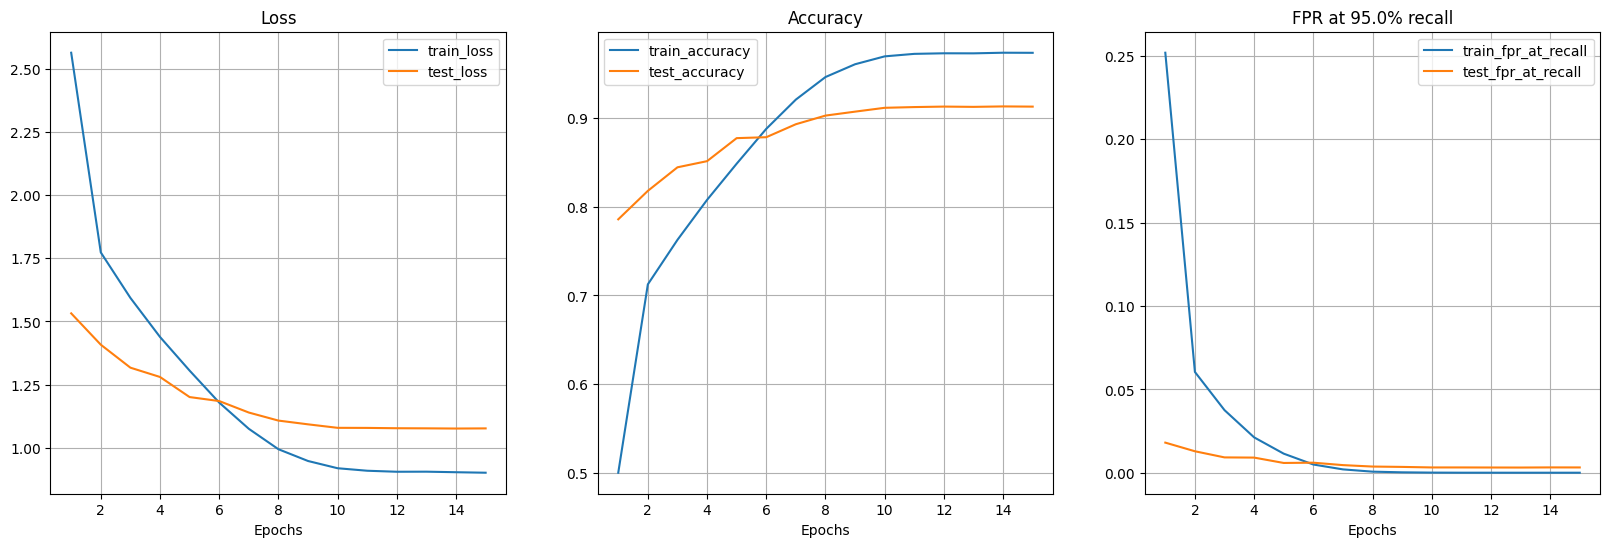

[INFO] Saving model to: ..\models\vitbase16_102_2024-01-04.pth


In [7]:
# Train the model
model_type="vitbase16_102_2025-01-04"
EPOCHS = 15
LR = 0.0001
model_name = f"{model_type}"
vitbase16_2_model_name = model_name + ".pth"

# Create optimizer
optimizer = torch.optim.AdamW(
    params=vitbase16_2_model.parameters(),
    lr=LR,
    betas=(0.9, 0.999),
    weight_decay=0.01
)

# Create loss function
loss_fn = torch.nn.CrossEntropyLoss(weight=loss_weights, label_smoothing=0.1)

# Set scheduler
#scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=5e-7),
scheduler = FixedLRSchedulerWrapper(
    scheduler=CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6),
    fixed_lr=1e-6,
    fixed_epoch=10
    )

# Set seeds
set_seeds(SEED)

# And train...
train = Trainer(
    model=vitbase16_2_model,
    save_best_model=True,
    mode="max", # Based on accuracy
    device=device
    )

vitbase16_2_results = train.fit(
    target_dir=MODEL_DIR,
    model_name=vitbase16_2_model_name,
    train_dataloader=train_dataloader_vitb,
    test_dataloader=test_dataloader_vitb,
    optimizer=optimizer,
    loss_fn=loss_fn,
    recall_threshold=0.95,
    scheduler=scheduler,
    epochs=EPOCHS,
    amp=True,
    enable_clipping=False,
    debug_mode=False,
    accumulation_steps=4,
    )